In [1]:
import json
import os
import sys
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%load_ext autoreload

%autoreload 2


In [77]:
import end_to_end_profiles as e2e
import profiler
import single_model_profiles as sm_profs

In [3]:
pipeline_three_df = profiler.load_pipeline_three_systemx()

/Users/crankshaw/miniconda2/envs/plots/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/crankshaw/miniconda2/envs/plots/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Skipping max_thru_hand_tuned


In [ ]:
pipeline_three_df

In [38]:
pipeline_one_df = profiler.load_pipeline_one_systemx()

Ambiguous profile setting for batch size 32
   num_gpus_per_replica  num_cpus_per_replica  mean_throughput_qps  \
7                     0                     1           734.385722   
8                     0                     1           727.123438   

   std_throughput_qps  p99_latency  mean_batch_size   inst_type    cost  \
7           26.031204     0.049538        15.894737  p2.8xlarge  0.0475   
8           19.105054     0.048751        15.860884  p2.8xlarge  0.0475   

                        fname  
7  results-171025_112953.json  
8  results-171025_113111.json  
Ambiguous profile setting for batch size 32
   num_gpus_per_replica  num_cpus_per_replica  mean_throughput_qps  \
7                     0                     1           734.385722   
8                     0                     1           727.123438   

   std_throughput_qps  p99_latency  mean_batch_size   inst_type    cost  \
7           26.031204     0.049538        15.894737  p2.8xlarge  0.0475   
8           19.105

In [ ]:
def plot_pipeline_exp(pipeline):
    plt.clf()
    fig, (ax_thru, ax_lat) = plt.subplots(ncols=2, nrows=1, sharey=True)
    fig.set_size_inches(12,5)
    colors = sns.color_palette("deep", n_colors=5)
    i = 0
    width = 0.1
    delta = 0.03
    for title, group in pipeline.groupby("name"):
        print(title)
        if "max" not in title:
            continue
        if "alexnet" in title:
            group = group.iloc[idxs_to_keep]
        box = ax_lat.boxplot(x=group["latency"], positions=group["cost"] + i*(width + delta), widths=width, patch_artist=True,
                            vert=False)
        for patch in box["boxes"]:
            patch.set_facecolor(colors[i])
        lat = group["estimated_latency"].iloc[0]
        cost_xs = np.arange(0.0, max(pipeline["cost"]) + 0.8, 0.1)
        lat_ys = lat * np.ones(len(cost_xs))
        ax_lat.plot(lat_ys, cost_xs, '--', linewidth=2, color=colors[i])
#         ax_thru.scatter(x=group["cost"], y=group["mean_throughput"], c=colors[i], marker="o", label=title)
#         ax_thru.scatter(x=group["cost"], y=group["estimated_thru"], c=colors[i], marker="^", label="")
        g_sorted = group.sort_values("cost")
        ax_thru.plot(g_sorted["mean_throughput"], g_sorted["cost"], color=colors[i], linestyle="solid", marker="o", label=title)
        ax_thru.plot(g_sorted["estimated_thru"], g_sorted["cost"], color=colors[i], linestyle="dashed", label="")

        i += 1
    ax_lat.set_xlabel("Latency (s)")
    ax_lat.set_ylim((1,max(pipeline["cost"]) + 0.8))
#     ax_thru.set_xlim((0,max(pipeline["cost"]) + 0.8))

    ax_lat.set_ylabel("Cost ($/hr)")
    ax_thru.set_xlabel("Throughput (queries/s)")
    ax_thru.set_ylabel("Cost ($/hr)")
    ax_thru.legend(loc=2)
#     ax_lat.legend(loc=2)


    plt.show()

In [ ]:
plot_pipeline_exp(pipeline_three_df)

In [ ]:
pipeline_one_df

In [ ]:
pipeline_three_df

In [29]:
single_model_profs = sm_profs.load_single_model_profiles()

In [30]:
single_model_profs.keys()

dict_keys(['alexnet', 'res152', 'res18', 'res50', 'inception', 'tf-kernel-svm', 'tf-log-reg', 'tf-resnet-feats'])

In [ ]:

single_model_profs["alexnet"].sort_values("mean_throughput_qps")

In [ ]:
single_model_profs["res50"].sort_values("mean_throughput_qps")

In [ ]:
single_model_profs["res152"].sort_values("mean_throughput_qps")

In [ ]:
probs = {'alexnet': 1.0, 'res50': 0.8077178975382568, 'res152': 0.4318030605455755}

In [ ]:
.12+.13+.12

In [ ]:
best_thruput = 0
bt_lat = 1000
bt_idxs = {"alex": -1, "res50": -1, "res152": -1}
bt_batches = {"alex": -1, "res50": -1, "res152": -1}

slo = 0.5

for ai, arow in single_model_profs["alexnet"].iterrows():
    for r50i, r50row in single_model_profs["res50"].iterrows():
        for r152i, r152row in single_model_profs["res152"].iterrows():
            total_latency = arow["p99_latency_ms"] + r50row["p99_latency_ms"] + r152row["p99_latency_ms"]
            thru = min(arow["mean_throughput_qps"], r50row["mean_throughput_qps"] / probs["res50"], r152row["mean_throughput_qps"] / probs["res152"])
            if thru > best_thruput and total_latency < slo:
                best_thruput = thru
                bt_lat = total_latency
                bt_idxs = {"alex": ai, "res50": r50i, "res152": r152i}
                bt_batches = {"alex": arow["mean_batch_size"], "res50": r50row["mean_batch_size"], "res152": r152row["mean_batch_size"]}



In [ ]:
best_thruput

In [ ]:
bt_batches

In [ ]:
bt_lat

In [21]:
single_model_profs["inception"].sort_values("mean_throughput_qps")

,num_gpus_per_replica,num_cpus_per_replica,mean_throughput_qps,std_throughput_qps,p99_latency,mean_batch_size,inst_type,cost,fname
0,1,1,22.949636,0.002764,0.046139,1.000000,p2.8xlarge,0.7475,results-171025_111631.json
1,1,1,35.572101,0.116163,0.097800,1.839258,p2.8xlarge,0.7475,results-171025_112140.json
2,1,1,48.387912,0.266863,0.149700,3.646527,p2.8xlarge,0.7475,results-171025_112656.json
3,1,1,54.581767,0.196076,0.203233,5.389042,p2.8xlarge,0.7475,results-171025_113152.json
4,1,1,57.692215,0.440102,0.228703,6.574611,p2.8xlarge,0.7475,results-171025_114020.json
5,1,1,62.561507,0.720362,0.302122,9.101839,p2.8xlarge,0.7475,results-171025_114556.json
11,1,1,68.088459,4.838110,1.211516,19.890741,p2.8xlarge,0.7475,results-171025_200443.json
6,1,1,68.666378,2.783552,0.952419,15.906433,p2.8xlarge,0.7475,results-171025_115100.json
7,1,1,70.099347,5.067141,1.435627,23.991453,p2.8xlarge,0.7475,results-171025_115524.json
8,1,1,70.409701,6.462417,1.829591,31.938384,p2.8xlarge,0.7475,results-171025_115942.json


In [32]:
single_model_profs["tf-log-reg"].sort_values("mean_throughput_qps")

,num_gpus_per_replica,num_cpus_per_replica,mean_throughput_qps,std_throughput_qps,p99_latency,mean_batch_size,inst_type,cost,fname
0,0,1,530.601362,1.777186,0.006152,1.000000,p2.8xlarge,0.0475,results-171025_111126.json
10,0,1,746.214482,2.200385,0.006147,1.457223,p2.8xlarge,0.0475,results-171025_112442.json
9,0,1,748.842296,3.727355,0.006170,1.477426,p2.8xlarge,0.0475,results-171025_112319.json
6,0,1,750.861918,5.971048,0.006306,1.533636,p2.8xlarge,0.0475,results-171025_111919.json
3,0,1,751.303908,5.457911,0.006267,1.496262,p2.8xlarge,0.0475,results-171025_111522.json
4,0,1,752.123346,4.892182,0.006521,1.527235,p2.8xlarge,0.0475,results-171025_111640.json
5,0,1,752.221280,4.069546,0.006228,1.522445,p2.8xlarge,0.0475,results-171025_111759.json
7,0,1,752.553114,5.281950,0.006332,1.455753,p2.8xlarge,0.0475,results-171025_112039.json
2,0,1,753.577229,4.833851,0.006155,1.446523,p2.8xlarge,0.0475,results-171025_111404.json
8,0,1,753.583865,5.047130,0.006179,1.458706,p2.8xlarge,0.0475,results-171025_112158.json


In [31]:
single_model_profs["tf-resnet-feats"].sort_values("mean_throughput_qps")

,num_gpus_per_replica,num_cpus_per_replica,mean_throughput_qps,std_throughput_qps,p99_latency,mean_batch_size,inst_type,cost,fname
0,1,1,6.678862,0.496573,1.212852,1.000000,p2.8xlarge,0.7475,results-171025_113035.json
1,1,1,12.586409,1.667796,1.674318,1.934265,p2.8xlarge,0.7475,results-171025_113652.json
2,1,1,20.866613,0.066418,0.352214,3.708922,p2.8xlarge,0.7475,results-171025_114351.json
3,1,1,25.922773,0.238865,0.421348,5.348842,p2.8xlarge,0.7475,results-171025_115159.json
4,1,1,28.968742,0.252181,0.464953,6.871234,p2.8xlarge,0.7475,results-171025_115822.json
5,1,1,32.571754,0.434962,0.589952,9.629928,p2.8xlarge,0.7475,results-171025_120412.json
6,1,1,36.829897,0.671149,0.815451,14.980033,p2.8xlarge,0.7475,results-171025_121341.json
7,1,1,41.057460,0.119753,1.121583,23.017094,p2.8xlarge,0.7475,results-171025_121956.json
8,1,1,44.441030,2.119653,1.366698,30.201010,p2.8xlarge,0.7475,results-171025_122532.json
10,1,1,47.007007,9.221762,3.038046,63.128571,p2.8xlarge,0.7475,results-171025_123741.json


In [35]:
single_model_profs["tf-kernel-svm"].sort_values("mean_throughput_qps")

,num_gpus_per_replica,num_cpus_per_replica,mean_throughput_qps,std_throughput_qps,p99_latency,mean_batch_size,inst_type,cost,fname
0,0,1,78.811110,0.449020,0.069199,1.000000,p2.8xlarge,0.0475,results-171025_111803.json
1,0,1,126.958785,0.345688,0.043925,1.750983,p2.8xlarge,0.0475,results-171025_112127.json
2,0,1,261.168332,2.873526,0.041111,3.825325,p2.8xlarge,0.0475,results-171025_112256.json
3,0,1,347.010577,3.887739,0.043545,5.482059,p2.8xlarge,0.0475,results-171025_112421.json
4,0,1,445.204804,5.928344,0.044823,7.503571,p2.8xlarge,0.0475,results-171025_112543.json
5,0,1,507.031546,4.028247,0.036220,8.661870,p2.8xlarge,0.0475,results-171025_112714.json
6,0,1,663.886783,22.736969,0.051032,13.960421,p2.8xlarge,0.0475,results-171025_112834.json
8,0,1,727.123438,19.105054,0.048751,15.860884,p2.8xlarge,0.0475,results-171025_113111.json
10,0,1,728.221195,12.578042,0.045907,15.751307,p2.8xlarge,0.0475,results-171025_113400.json
9,0,1,733.084880,11.950343,0.045785,15.709677,p2.8xlarge,0.0475,results-171025_113236.json


In [ ]:
pipeline_three_df[pipeline_three_df["name"] == "alexnet_cpu_max_thru"].sort_values("cost").iloc[idxs_to_keep]

In [ ]:
idxs_to_keep = [7, 10, 13, 0, 1]

In [15]:
import end_to_end_profiles as e2e

pipeline_one_single_proc = e2e.load_pipeline_one_single_proc()


In [17]:
pipeline_one_single_proc

,cost,mean_latency,mean_throughput,name,num_replicas,p99_latency
0,1.59,1.234579,51.836714,max_thru,1,1.310346
1,3.18,1.245383,102.786399,max_thru,2,1.354510
2,4.77,1.237378,155.221108,max_thru,3,1.345724
3,6.36,1.249625,204.898440,max_thru,4,1.367540
0,1.59,0.090452,11.048699,min_lat,1,0.100457
1,3.18,0.096901,20.635533,min_lat,2,0.107596
2,4.77,0.096239,31.158461,min_lat,3,0.108436
3,6.36,0.099542,40.162823,min_lat,4,0.113352


In [92]:
def cost_across_systems(single_proc_df, system_x_df, tf_serving_df):
    plt.clf()
    fig, (ax_thru, ax_lat) = plt.subplots(ncols=2, nrows=1, sharey=True)
    fig.set_size_inches(12,5)
    colors = sns.color_palette("deep", n_colors=7)
    i = 0
    width = 0.1
    delta = 0.03
    for title, group in system_x_df.groupby("name"):
        print(title)
        if title == "max_throughput" or title == "min_latency":
#         if title == "min_latency":

            box = ax_lat.boxplot(x=group["latency"], positions=group["cost"] + i*(width + delta), widths=width, patch_artist=True,
                                vert=False)
            for patch in box["boxes"]:
                patch.set_facecolor(colors[i])
            group = group.sort_values("mean_throughput")
            ax_thru.step(x=group["mean_throughput"], y=group["cost"], color=colors[i], marker="o",
                         label="System X {}".format(title))

            i += 1
    
    for title, group in tf_serving_df.groupby("name"):
        print(title)
        if title == "max_thru" or title == "min_lat":
#         if title == "min_latency":

            box = ax_lat.boxplot(x=group["latency"], positions=group["cost"] + i*(width + delta), widths=width, patch_artist=True,
                                vert=False)
            for patch in box["boxes"]:
                patch.set_facecolor(colors[i])
            group = group.sort_values("mean_throughput")
            ax_thru.step(x=group["mean_throughput"], y=group["cost"], color=colors[i], marker="o",
                         label="TF Serving {}".format(title))

            i += 1
            
    for title, group in single_proc_df.groupby("name"):
        continue
        print(title)
        if title == "max_thru" or title == "min_lat":
#         if title == "min_lat":

            group = group.sort_values("mean_throughput")
            ax_lat.scatter(group["p99_latency"], group["cost"], color=colors[i], linestyle="solid")
            ax_thru.step(x=group["mean_throughput"], y=group["cost"], color=colors[i], marker="x",
                         label="Single proc {}".format(title))

            i += 1

    ax_lat.set_xlabel("Latency (s)")
    ax_lat.set_ylim((1,max(max(system_x_df["cost"]), max(single_proc_df["cost"])) + 0.8))

    ax_lat.set_ylabel("Cost ($/hr)")
    ax_thru.set_xlabel("Throughput (queries/s)")
    ax_thru.set_ylabel("Cost ($/hr)")
    ax_thru.legend(loc=0)

    plt.show()

375ms
500ms
max_throughput
min_latency
max_thru
min_lat


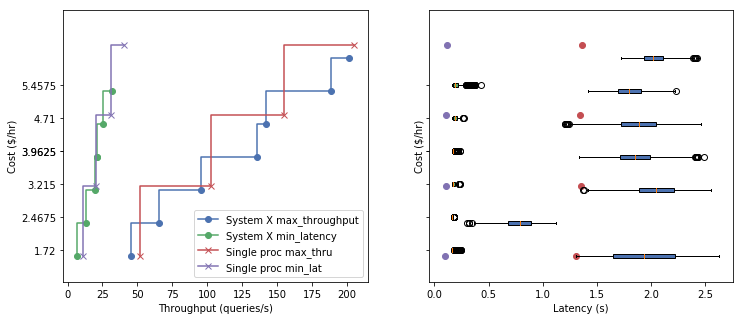

In [72]:
cost_across_systems(pipeline_one_single_proc, pipeline_one_df)

In [45]:
pipeline_one_df

,name,mean_throughput,estimated_thru,p99_latency,p95_latency,estimated_latency,cost,latency
0,375ms,16.737902,20.866613,0.359794,0.348370,1.217668,1.5900,"[0.285565, 0.205302, 0.341708, 0.282018, 0.324..."
1,375ms,34.195283,41.733226,0.366489,0.358112,1.217668,2.3375,"[0.215835, 0.201095, 0.335133, 0.364763, 0.306..."
2,375ms,50.466090,62.599839,0.362790,0.350773,1.217668,3.0850,"[0.249805, 0.183143, 0.248921, 0.22867, 0.2487..."
3,375ms,60.547956,83.466452,0.368364,0.350546,1.217668,4.5800,"[0.303041, 0.327872, 0.331895, 0.365095, 0.315..."
4,375ms,54.935798,68.088459,0.354988,0.343530,1.217668,3.8325,"[0.282336, 0.264385, 0.227878, 0.24623, 0.2270..."
5,375ms,71.192964,104.333065,0.358759,0.339845,1.217668,5.3275,"[0.201397, 0.187477, 0.347317, 0.333644, 0.362..."
6,375ms,79.438263,125.199677,0.367609,0.343872,1.217668,6.0750,"[0.319268, 0.280962, 0.293911, 0.306837, 0.269..."
0,500ms,25.539010,25.922773,0.487155,0.472209,1.217668,1.5900,"[0.331289, 0.409878, 0.375783, 0.468961, 0.407..."
1,500ms,50.066721,51.845545,0.483020,0.464893,1.217668,2.3375,"[0.349733, 0.36984, 0.329935, 0.299173, 0.3193..."
2,500ms,62.193386,68.088459,0.423909,0.405055,1.217668,3.0850,"[0.283282, 0.333023, 0.304248, 0.274416, 0.260..."


In [48]:
pipeline_one_single_proc

,cost,mean_latency,mean_throughput,name,num_replicas,p99_latency
0,1.59,1.234579,51.836714,max_thru,1,1.310346
1,3.18,1.245383,102.786399,max_thru,2,1.354510
2,4.77,1.237378,155.221108,max_thru,3,1.345724
3,6.36,1.249625,204.898440,max_thru,4,1.367540
0,1.59,0.090452,11.048699,min_lat,1,0.100457
1,3.18,0.096901,20.635533,min_lat,2,0.107596
2,4.77,0.096239,31.158461,min_lat,3,0.108436
3,6.36,0.099542,40.162823,min_lat,4,0.113352


In [74]:
single_model_profs["inception"].sort_values("mean_throughput_qps")

,num_gpus_per_replica,num_cpus_per_replica,mean_throughput_qps,std_throughput_qps,p99_latency,mean_batch_size,inst_type,cost,fname
0,1,1,22.949636,0.002764,0.046139,1.000000,p2.8xlarge,0.7475,results-171025_111631.json
1,1,1,35.572101,0.116163,0.097800,1.839258,p2.8xlarge,0.7475,results-171025_112140.json
2,1,1,48.387912,0.266863,0.149700,3.646527,p2.8xlarge,0.7475,results-171025_112656.json
3,1,1,54.581767,0.196076,0.203233,5.389042,p2.8xlarge,0.7475,results-171025_113152.json
4,1,1,57.692215,0.440102,0.228703,6.574611,p2.8xlarge,0.7475,results-171025_114020.json
5,1,1,62.561507,0.720362,0.302122,9.101839,p2.8xlarge,0.7475,results-171025_114556.json
11,1,1,68.088459,4.838110,1.211516,19.890741,p2.8xlarge,0.7475,results-171025_200443.json
6,1,1,68.666378,2.783552,0.952419,15.906433,p2.8xlarge,0.7475,results-171025_115100.json
7,1,1,70.099347,5.067141,1.435627,23.991453,p2.8xlarge,0.7475,results-171025_115524.json
8,1,1,70.409701,6.462417,1.829591,31.938384,p2.8xlarge,0.7475,results-171025_115942.json


In [73]:
single_model_profs["res18"].sort_values("mean_throughput_qps")

,num_gpus_per_replica,num_cpus_per_replica,mean_throughput_qps,std_throughput_qps,p99_latency,mean_batch_size,inst_type,cost,fname
0,1,1,74.184502,0.023690,0.016428,1.000000,p2.8xlarge,0.7475,results-171024_194435.json
1,1,1,90.753700,0.141792,0.035104,1.394116,p2.8xlarge,0.7475,results-171024_195151.json
2,1,1,107.538815,0.477243,0.065693,3.036288,p2.8xlarge,0.7475,results-171024_195632.json
3,1,1,110.053353,0.367193,0.067394,3.643807,p2.8xlarge,0.7475,results-171024_200050.json
5,1,1,119.900936,0.487748,0.078394,4.493260,p2.8xlarge,0.7475,results-171024_201041.json
4,1,1,123.008849,0.473534,0.105298,5.613705,p2.8xlarge,0.7475,results-171024_200510.json
6,1,1,126.282040,0.924127,0.159633,9.975136,p2.8xlarge,0.7475,results-171024_201442.json
8,1,1,126.853888,1.140972,0.147012,9.091116,p2.8xlarge,0.7475,results-171024_202259.json
9,1,1,144.884470,1.890513,0.384073,27.412939,p2.8xlarge,0.7475,results-171024_202738.json
7,1,1,144.931343,2.031514,0.205264,14.656911,p2.8xlarge,0.7475,results-171024_201827.json


In [88]:
import end_to_end_profiles as e2e

pipeline_one_tfserving = e2e.load_tfserving_end_to_end()

In [89]:
pipeline_one_tfserving

,config,cost,latency,mean_throughput,name,p95_latency,p99_latency,standard_dev_throughput
0,"[{'name': 'inception', 'cpus_per_replica': 2, ...",1.780,"[1.937485, 1.633534, 1.57419, 1.807961, 1.6507...",36.374484,max_thru,2.091432,2.338587,0.388441
1,"[{'name': 'inception', 'cpus_per_replica': 2, ...",2.575,"[1.036986, 0.944567, 1.179942, 0.952674, 1.221...",63.707063,max_thru,2.326371,2.746335,0.924452
2,"[{'name': 'inception', 'cpus_per_replica': 2, ...",3.370,"[2.11279, 1.819615, 1.575978, 1.874477, 1.4395...",74.162492,max_thru,2.201037,2.693825,1.303273
3,"[{'name': 'inception', 'cpus_per_replica': 2, ...",4.165,"[2.752776, 2.826466, 2.770004, 3.20376, 2.6411...",95.734762,max_thru,2.998077,3.481123,2.422248
4,"[{'name': 'inception', 'cpus_per_replica': 2, ...",4.960,"[1.359936, 1.087656, 1.427561, 1.439654, 1.348...",111.482119,max_thru,2.858963,3.169423,2.500371
5,"[{'name': 'inception', 'cpus_per_replica': 2, ...",5.755,"[2.734466, 2.611775, 2.173062, 2.272713, 2.121...",144.081378,max_thru,2.409329,2.603621,2.407381
6,"[{'name': 'inception', 'cpus_per_replica': 2, ...",6.550,"[1.832582, 1.419666, 2.155309, 1.530251, 1.668...",169.438223,max_thru,2.424474,2.708744,3.296158
0,"[{'name': 'inception', 'cpus_per_replica': 2, ...",1.780,"[0.151502, 0.152282, 0.162672, 0.144447, 0.140...",11.008765,min_lat,0.162552,0.172026,0.011127
1,"[{'name': 'inception', 'cpus_per_replica': 2, ...",2.575,"[0.146687, 0.166929, 0.146345, 0.14484, 0.1327...",21.328060,min_lat,0.147641,0.158785,0.037833
2,"[{'name': 'inception', 'cpus_per_replica': 2, ...",3.370,"[0.144658, 0.142439, 0.144716, 0.13849, 0.1696...",22.081307,min_lat,0.158368,0.168808,0.059065


375ms
500ms
max_throughput
min_latency
max_thru
min_lat


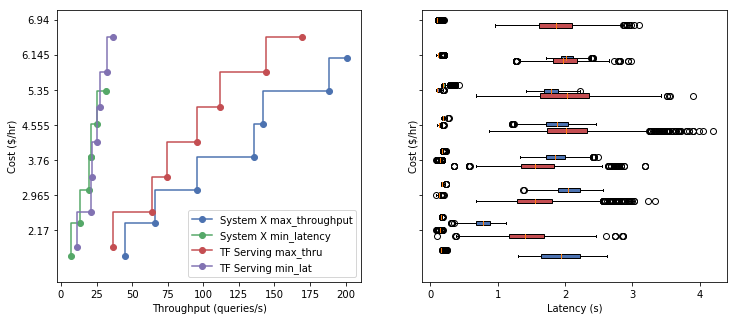

In [93]:
cost_across_systems(pipeline_one_single_proc, pipeline_one_df, pipeline_one_tfserving)